In [29]:
### calculate responsive units and plot bargraph

# imports
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import matplotlib.patches as mpatches
from scipy.stats import chi2_contingency

### functions
def makefolder(path):
    """Creates folder if it does not exist"""
    if not os.path.exists(path):
        os.makedirs(path)

In [28]:
# take the mean time warped traces and perform a basic statistical test to determine 'responsiveness'
# wilcoxen signed rank test comparing baseline to 'sensory', 'decision', and 'reward' epochs


def calculatepvalues_multipleepochs(data, savename, savepath, threshold=0.05):
    savepvalues = np.zeros((data.shape[0], data.shape[2]))
    sensoryonly = np.zeros((data.shape[0], 2))

    # loop through all the data

    for n in range(data.shape[0]):
        # going through each neuron

        for t in range(data.shape[2]):
            # calculate the baseline
            baseline = data[n, :10, t]
            # calculate the sensory epoch
            sensory = data[n, 10:20, t]

            # perform the wilcoxon signed rank test
            savepvalues[n, t] = mannwhitneyu(baseline, sensory)[1]


            if np.count_nonzero(savepvalues[n, t] < threshold) > 0:
                sensoryonly[n, t] = 1
            else:
                sensoryonly[n, t] = 0


    np.save(savepath + savename + '_responsivesensory.npy', sensoryonly)
    np.save(savepath + savename + '_pvalues.npy', savepvalues)
    return savepvalues

# load the data. data=timewarped firing rate, info=neuroninformation, data2=timewarpedfiring rate only 2 classes
cwd = os.getcwd()
savename = 'experiment1'   # same as in previous cell
folderpath = os.path.join(cwd, 'data_timewarped/')

masterlistpath = os.path.join(cwd, 'masterlist_experiment1task.csv')
masterlist = np.loadtxt(masterlistpath, delimiter=',', dtype=str)

variations = ['prelearning', 'postlearning']
savepath = os.path.join(cwd, "Figure2F/")
makefolder(savepath)


for v, variation in enumerate(variations):
    data = np.load(folderpath + variation + '.npy')
    pvalues = calculatepvalues_multipleepochs(data, variation, savepath, threshold=0.05)



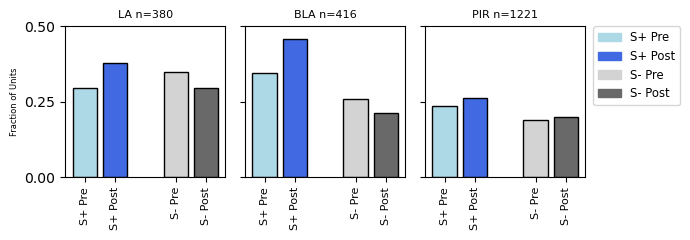

In [33]:
### plot Figure2F and quantify

def barplot_responsivepct_2conditions(info, pvalue1, pvalue2, savename, savepath):
    areas = ['LA', 'BLA', 'PIR']
    plt.close()
    fig, ax = plt.subplots(1, len(areas), figsize=(len(areas)*2+1,2.5), sharey='row', sharex='all')
    rewardedpre = []
    rewardedpost = []
    unrewardedpre = []
    unrewardedpost = []

    for a, area in enumerate(areas):
        results = []
        pvalue1_area = pvalue1[info[:, 2] == area]
        pvalue2_area = pvalue2[info[:, 2] == area]

        rewarded_condition1 = np.count_nonzero(pvalue1_area[:, 0] == 1)
        rewarded_condition2 = np.count_nonzero(pvalue2_area[:, 0] == 1)
        unrewarded_condition1 = np.count_nonzero(pvalue1_area[:, 1] == 1)
        unrewarded_condition2 = np.count_nonzero(pvalue2_area[:, 1] == 1)
        totalunits = len(pvalue1_area)

        responsive_rewardedc1 = rewarded_condition1 / totalunits
        responsive_rewardedc2 = rewarded_condition2 / totalunits
        responsive_unrewardedc1 = unrewarded_condition1 / totalunits
        responsive_unrewardedc2 = unrewarded_condition2 / totalunits

        rewardedtable = [[rewarded_condition1, rewarded_condition2], [totalunits-rewarded_condition1, totalunits-rewarded_condition2]]
        chi2, p, dof, expected = chi2_contingency(rewardedtable)
        # Calculate Cramér's V
        n = np.sum(rewardedtable)
        min_dim = 1
        cramers_v = np.sqrt(chi2 / (n * min_dim))

        results.append(area + ' rewarded')
        results.append(f"Chi-squared: {chi2}")
        results.append('N= ' + str(totalunits))
        results.append(f"P-value: {p}")
        results.append(f"Degrees of freedom: {dof}")
        results.append(f"Cramér's V: {cramers_v}")

        unrewardedtable = [[unrewarded_condition1, unrewarded_condition2], [totalunits-unrewarded_condition1, totalunits-unrewarded_condition2]]
        chi2, p, dof, expected = chi2_contingency(unrewardedtable)
        # Calculate Cramér's V
        n = np.sum(unrewardedtable)
        min_dim = 1
        cramers_v = np.sqrt(chi2 / (n * min_dim))

        results.append(area + ' unrewarded')
        results.append(f"Chi-squared: {chi2}")
        results.append('N= ' + str(totalunits))
        results.append(f"P-value: {p}")
        results.append(f"Degrees of freedom: {dof}")
        results.append(f"Cramér's V: {cramers_v}")

        # create a bar graph with individual graphs per area and percentages per condition
        bars = ax[a].bar((0, 1, 3, 4), (responsive_rewardedc1, responsive_rewardedc2, responsive_unrewardedc1, responsive_unrewardedc2),
                  color=('lightblue', 'royalblue', 'lightgrey', 'dimgrey'), edgecolor='black')
        ax[a].set_title(area + ' n=' + str(totalunits), fontsize=8)
        ax[a].set_ylim(0, .5)

        ax[a].set_yticks((0, 0.25, 0.5))

        ax[a].set_xticks((0, 1, 3, 4))
        ax[a].set_xticklabels(('S+ Pre', 'S+ Post', 'S- Pre', 'S- Post'), fontsize=8, rotation=90)

        rewardedpre = np.append(rewardedpre, responsive_rewardedc1)
        rewardedpost = np.append(rewardedpost, responsive_rewardedc2)
        unrewardedpre = np.append(unrewardedpre, responsive_unrewardedc1)
        unrewardedpost = np.append(unrewardedpost, responsive_unrewardedc2)

        np.savetxt(savepath + savename + '_' + area + '_results.txt', results, fmt='%s', delimiter='\n')

    # Create legend patches
    legend_patches = [mpatches.Patch(color=bar.get_facecolor(), label=label) for bar, label in
                      zip(bars, ['S+ Pre', 'S+ Post', 'S- Pre', 'S- Post'])]

    # Add the legend to the figure
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
               fontsize='small')
    ax[0].set_ylabel('Fraction of Units', fontsize=6)
    #ax[a].set_ylabel('Percentage Responsive', fontsize=6)
    plt.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(savepath + savename + '_responsiveunits.svg', format='svg')

    return(rewardedpre, rewardedpost, unrewardedpre, unrewardedpost)

cwd = os.getcwd()
savename = 'experiment1'   # same as in previous cell
folderpath = os.path.join(cwd, 'Figure2F/')

pvalue1 = np.load(folderpath + 'prelearning_responsivesensory.npy')
pvalue2 = np.load(folderpath + 'postlearning_responsivesensory.npy')

masterlistpath = os.path.join(cwd, 'masterlist_experiment1task.csv')
masterlist = np.loadtxt(masterlistpath, delimiter=',', dtype=str)


[rewardedpre, rewardedpost, unrewardedpre, unrewardedpost] = barplot_responsivepct_2conditions(masterlist, pvalue1, pvalue2, savename, folderpath)
